# Edge Detection Using U-Net Architecture

### Reference

- https://github.com/usuyama/pytorch-unet
- https://github.com/milesial/Pytorch-UNet


## Preprocessing

In [1]:
import cv2
import matplotlib.pyplot as plt
import scipy.io
import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy import ndimage, misc
from sklearn.metrics import average_precision_score

In [2]:
folder = 'BSR_unzip/BSR/BSDS500/data/'

def load_images(folder):
    images = []
    files = os.listdir(folder)
    files = [i for i in files if '.jpg' in i]
    files.sort()
    for filename in files:
        img = cv2.imread(os.path.join(folder,filename))
        if img.shape == (481, 321, 3):
            img = np.transpose(img, (1, 0, 2)) 
        ## do padding
        #img = np.pad(img, ((0, 1), (0, 1), (0, 0)), mode='constant', constant_values=0)
        # do cropping
        img = img[:320, :480, :]
        if img is not None:
            images.append(img)
    return images

def load_labels(folder):
    labels = []
    files = os.listdir(folder)
    files.sort()
    for filename in files:
        gts_len = len((scipy.io.loadmat(os.path.join(folder,filename)))['groundTruth'][0])
        gt_majority = np.zeros((scipy.io.loadmat(os.path.join(folder,filename)))['groundTruth'][0][0][0][0][1].shape)
        for i in range(gts_len):
            label = (scipy.io.loadmat(os.path.join(folder,filename)))['groundTruth'][0][i][0][0][1]
            label = np.where(label == 0, -1, 1)
            gt_majority += label
        gt_majority = np.where(gt_majority >= -1, 1, 0)
        if gt_majority.shape == (481, 321):
            gt_majority = gt_majority.T
        ## do padding
        #gt_majority = np.pad(gt_majority, ((0, 1), (0, 1)), mode='constant', constant_values=0)
        # do cropping
        gt_majority = gt_majority[:320, :480]
        labels.append(gt_majority)
            
    return labels

# Load Images
xtrain_org = load_images(folder + 'images/train')
xtest = load_images(folder + 'images/test')
xval_org = load_images(folder + 'images/val')

# Load Ground Truths Using Majority Vote Notion
ytrain_org = load_labels(folder + 'groundTruth/train')
ytest = load_labels(folder + 'groundTruth/test')
yval_org = load_labels(folder + 'groundTruth/val')

#plt.imshow(xtrain[0])
#plt.imshow(ytrain[0])
#
#plt.imshow(xtrain[1])
#plt.imshow(ytrain[1])

In [3]:
## Populate images by rotating (Image augmentation)

def augment_image(img_list, split = 8):
    my_list = []
    for i in range(len(img_list)):
        for j in range(split):
            my_list.append(ndimage.rotate(img_list[i], angle=j*(360/split), reshape=False))
    return my_list

In [4]:
# This takes a while
xtrain = augment_image(xtrain_org)
xval = augment_image(xval_org)

ytrain = augment_image(ytrain_org)
yval = augment_image(yval_org)

In [6]:
del xtrain_org, xval_org, ytrain_org, yval_org

In [7]:
pickle.dump((xtrain, xtest, xval, ytrain, ytest, yval), open( "save.p", "wb" ) )

## Load Preprocessed Data

In [3]:
# Data for U-Net
#(xtrain, xtest, xval, ytrain, ytest, yval) = pickle.load(open("save.p","rb"))

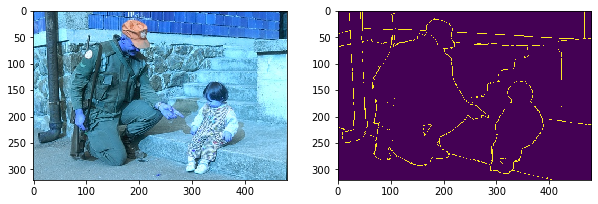

In [8]:
plt.subplots(1,2,figsize=(10,10))

index = 448

plt.subplot(1, 2, 1)
plt.imshow(xtrain[index])

plt.subplot(1, 2, 2)
plt.imshow(ytrain[index])

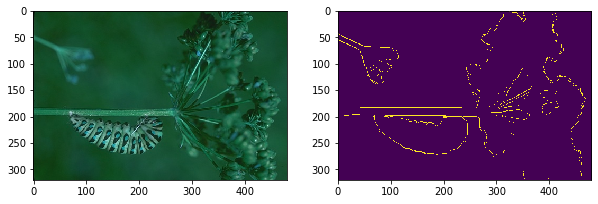

In [9]:
plt.subplots(1,2,figsize=(10,10))

index = 150

plt.subplot(1, 2, 1)
plt.imshow(xtest[index])

plt.subplot(1, 2, 2)
plt.imshow(ytest[index])

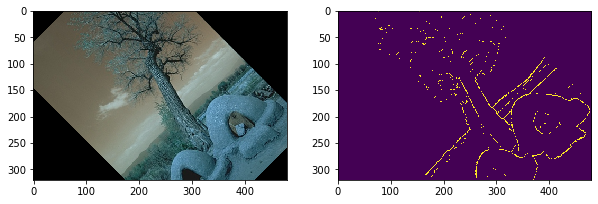

In [10]:
plt.subplots(1,2,figsize=(10,10))

index = 655

plt.subplot(1, 2, 1)
plt.imshow(xval[index])

plt.subplot(1, 2, 2)
plt.imshow(yval[index])

In [11]:
# Stack images along a new axis

xtrain = np.vstack([i[None, :, :, :] for i in xtrain])
xtest = np.vstack([i[None, :, :, :] for i in xtest])
xval = np.vstack([i[None, :, :, :] for i in xval])

xtrain.shape, xtest.shape, xval.shape

((1600, 320, 480, 3), (200, 320, 480, 3), (800, 320, 480, 3))

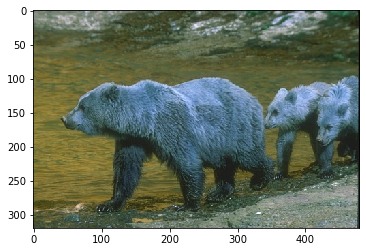

In [12]:
plt.imshow(xtrain[0, :, :, :])

In [13]:
# Stack labels along a new axis

ytrain = np.vstack([i[None, :, :] for i in ytrain])
ytest = np.vstack([i[None, :, :] for i in ytest])
yval = np.vstack([i[None, :, :] for i in yval])

ytrain.shape, ytest.shape, yval.shape

((1600, 320, 480), (200, 320, 480), (800, 320, 480))

In [14]:
## Create tensors from images
import torch

xtrain = torch.from_numpy(np.transpose(xtrain, [0, 3, 1, 2]))
xtest = torch.from_numpy(np.transpose(xtest, [0, 3, 1, 2]))
xval = torch.from_numpy(np.transpose(xval, [0, 3, 1, 2]))

xtrain.shape, xtest.shape, xval.shape

(torch.Size([1600, 3, 320, 480]),
 torch.Size([200, 3, 320, 480]),
 torch.Size([800, 3, 320, 480]))

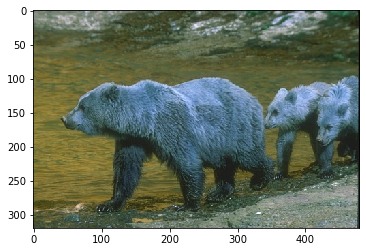

In [15]:
plt.imshow(np.transpose(xtrain.numpy()[0, :, :, :], [1, 2, 0]))

In [16]:
## Create tensors from labels
ytrain = torch.from_numpy(ytrain).view(len(ytrain), 1, 320, 480)
ytest = torch.from_numpy(ytest).view(len(ytest), 1, 320, 480)
yval = torch.from_numpy(yval).view(len(yval), 1, 320, 480)

ytrain.shape, ytest.shape, yval.shape

(torch.Size([1600, 1, 320, 480]),
 torch.Size([200, 1, 320, 480]),
 torch.Size([800, 1, 320, 480]))

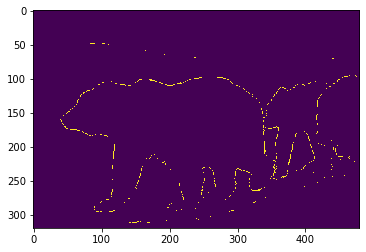

In [17]:
plt.imshow(ytrain[0,0,:,:])

In [18]:
# change data types
xtrain = xtrain.type('torch.FloatTensor')
xtest = xtest.type('torch.FloatTensor')
xval = xval.type('torch.FloatTensor')

ytrain = ytrain.type('torch.FloatTensor')
ytest = ytest.type('torch.FloatTensor')
yval = yval.type('torch.FloatTensor')

In [19]:
# Adjust data, make it usable for dataloader
train_set = [[xtrain[i, :, :, :], ytrain[i, :, :]] for i in range(xtrain.shape[0])]
test_set = [[xtest[i, :, :, :], ytest[i, :, :]] for i in range(xtest.shape[0])]
val_set = [[xval[i, :, :, :], yval[i, :, :]] for i in range(xval.shape[0])]

In [20]:
train_set[0][0].shape, train_set[0][1].shape

(torch.Size([3, 320, 480]), torch.Size([1, 320, 480]))

In [21]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 1

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 1600, 'val': 800}

In [22]:
del xtrain, xval, ytrain, yval

## Training

In [23]:
# Define U-net Model

import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        #out = torch.sigmoid(out)
        
        return out

In [24]:
from torchsummary import summary
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(1)
model = model.to(device)

summary(model, input_size=(3, 320, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 480]           1,792
              ReLU-2         [-1, 64, 320, 480]               0
            Conv2d-3         [-1, 64, 320, 480]          36,928
              ReLU-4         [-1, 64, 320, 480]               0
         MaxPool2d-5         [-1, 64, 160, 240]               0
            Conv2d-6        [-1, 128, 160, 240]          73,856
              ReLU-7        [-1, 128, 160, 240]               0
            Conv2d-8        [-1, 128, 160, 240]         147,584
              ReLU-9        [-1, 128, 160, 240]               0
        MaxPool2d-10         [-1, 128, 80, 120]               0
           Conv2d-11         [-1, 256, 80, 120]         295,168
             ReLU-12         [-1, 256, 80, 120]               0
           Conv2d-13         [-1, 256, 80, 120]         590,080
             ReLU-14         [-1, 256, 

In [26]:
from collections import defaultdict
import torch.nn.functional as F

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            
            if phase == 'val':
                val_losses.append(epoch_loss)
            else:
                train_losses.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, best_loss

In [27]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

model = UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model, train_losses, val_losses, best_loss = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=5)

cuda:0
Epoch 0/4
----------
LR 0.0001


/home/iocak/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/iocak/.local/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.094653, dice: 0.859869, loss: 0.477261
val: bce: 0.078796, dice: 0.804430, loss: 0.441613
saving best model
1m 53s
Epoch 1/4
----------
LR 0.0001
train: bce: 0.084419, dice: 0.791540, loss: 0.437979
val: bce: 0.089094, dice: 0.782012, loss: 0.435553
saving best model
1m 55s
Epoch 2/4
----------
LR 0.0001
train: bce: 0.083266, dice: 0.775903, loss: 0.429584
val: bce: 0.087516, dice: 0.801357, loss: 0.444436
1m 55s
Epoch 3/4
----------
LR 0.0001
train: bce: 0.082201, dice: 0.764065, loss: 0.423133
val: bce: 0.082453, dice: 0.771853, loss: 0.427153
saving best model
1m 55s
Epoch 4/4
----------
LR 0.0001
train: bce: 0.081551, dice: 0.755499, loss: 0.418525
val: bce: 0.081375, dice: 0.770486, loss: 0.425930
saving best model
1m 55s
Best val loss: 0.425930


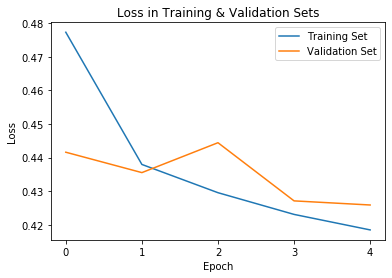

In [33]:
# plot train vs validation set error

plt.plot(range(len(train_losses)), train_losses, label = 'Training Set')
plt.plot(range(len(val_losses)), val_losses, label = 'Validation Set')
plt.xticks(range(len(val_losses)))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss in Training & Validation Sets')
plt.show()

## Prediction

In [34]:
# prediction for 1 instance

import math

model.eval()   # Set model to evaluate mode

test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
pred = pred[0, 0, :, :]
pred_prob = pred.copy()
pred = np.where(pred>=0.5, 1, 0)

gt = ytest.numpy()[0, 0, :, :]

org = np.transpose(xtest.numpy()[0, :, :, :], [1, 2, 0]).astype(int)

In [35]:
# accuracy
accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

# precision
tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
precision = tp / (tp + fp)

# recall
fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
recall = tp / (tp + fn)

# f-value
fvalue = 2 * precision * recall / (precision + recall)

# mean Average Precision
m_ap = average_precision_score(y_true = gt.reshape(-1), y_score = pred_prob.reshape(-1))

In [36]:
print(f'Accuracy: {round(accuracy, 4)}, Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F-value: {round(fvalue, 4)}, m-AP: {round(m_ap, 4)}')

Accuracy: 0.9689, Precision: 0.284, Recall: 0.4709, F-value: 0.3543, m-AP: 0.2879


Text(0.5, 1.0, 'Pred')

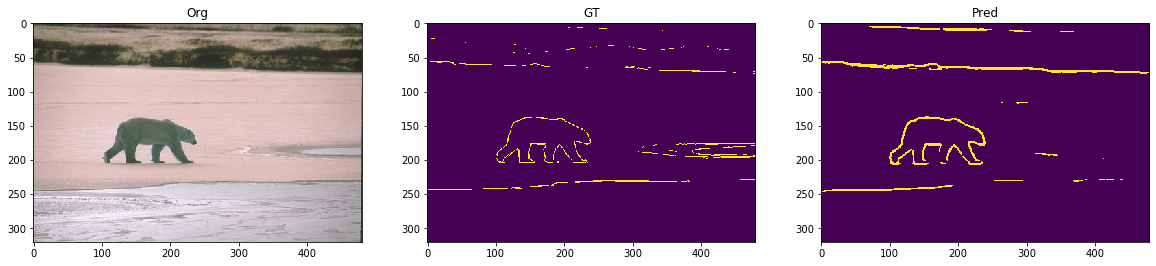

In [37]:
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org)
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt)
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(pred)
plt.title('Pred')

In [181]:
num_it = len(test_set)

model.eval()   # Set model to evaluate mode

test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
iterator = iter(test_loader)

org_list = []
gt_list = []
pred_list = []
accuracy_list = []
precision_list = []
recall_list = []
fvalue_list = []
map_list = []

for i in range(num_it):
    inputs, labels = next(iterator)
    inputs = inputs.to(device)
    labels = labels.to(device)

    pred = model(inputs)
    pred = torch.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    pred = pred[0, 0, :, :]
    
    # arrays
    pred_prob = pred.copy()
    pred = np.where(pred>=0.5, 1, 0)
    gt = ytest.numpy()[i, 0, :, :]
    org = np.transpose(xtest.numpy()[i, :, :, :], [1, 2, 0]).astype(int)
    
    # metrics
    # accuracy
    accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

    # precision
    tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
    fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
    precision = tp / (tp + fp)

    # recall
    fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
    recall = tp / (tp + fn)

    # f-value
    if (precision == 0) & (recall == 0):
        fvalue = 0
    else:
        fvalue = 2 * precision * recall / (precision + recall)
        
    # mean Average Precision
    m_ap = average_precision_score(y_true = gt.reshape(-1), y_score = pred_prob.reshape(-1))
    
    print(f'Accuracy: {round(accuracy, 4)}, Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F-value: {round(fvalue, 4)}, m-AP: {round(m_ap, 4)}')
    
    org_list.append(org)
    gt_list.append(gt)
    pred_list.append(pred)
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    fvalue_list.append(fvalue)
    map_list.append(m_ap)

Accuracy: 0.9752, Precision: 0.3447, Recall: 0.4067, F-value: 0.3731, m-AP: 0.2915
Accuracy: 0.9759, Precision: 0.2425, Recall: 0.2975, F-value: 0.2672, m-AP: 0.2069
Accuracy: 0.9818, Precision: 0.2695, Recall: 0.2584, F-value: 0.2638, m-AP: 0.1977
Accuracy: 0.9646, Precision: 0.191, Recall: 0.4863, F-value: 0.2742, m-AP: 0.2404
Accuracy: 0.9789, Precision: 0.3072, Recall: 0.3138, F-value: 0.3105, m-AP: 0.2111
Accuracy: 0.9541, Precision: 0.1825, Recall: 0.7037, F-value: 0.2898, m-AP: 0.2045
Accuracy: 0.9689, Precision: 0.2758, Recall: 0.2524, F-value: 0.2636, m-AP: 0.1904
Accuracy: 0.9656, Precision: 0.1397, Recall: 0.4926, F-value: 0.2177, m-AP: 0.1717
Accuracy: 0.9836, Precision: 0.2194, Recall: 0.6026, F-value: 0.3217, m-AP: 0.2481
Accuracy: 0.9715, Precision: 0.2845, Recall: 0.2553, F-value: 0.2691, m-AP: 0.197
Accuracy: 0.9742, Precision: 0.1163, Recall: 0.1246, F-value: 0.1203, m-AP: 0.0746
Accuracy: 0.9772, Precision: 0.2107, Recall: 0.4458, F-value: 0.2862, m-AP: 0.2247
Accura

Accuracy: 0.973, Precision: 0.2736, Recall: 0.4437, F-value: 0.3385, m-AP: 0.2592
Accuracy: 0.9387, Precision: 0.2874, Recall: 0.4689, F-value: 0.3563, m-AP: 0.2869
Accuracy: 0.966, Precision: 0.2397, Recall: 0.2861, F-value: 0.2608, m-AP: 0.1717
Accuracy: 0.9327, Precision: 0.1345, Recall: 0.4145, F-value: 0.2031, m-AP: 0.1217
Accuracy: 0.9732, Precision: 0.1981, Recall: 0.5243, F-value: 0.2876, m-AP: 0.2781
Accuracy: 0.9388, Precision: 0.2285, Recall: 0.5318, F-value: 0.3197, m-AP: 0.2282
Accuracy: 0.9676, Precision: 0.2831, Recall: 0.6573, F-value: 0.3958, m-AP: 0.2799
Accuracy: 0.9436, Precision: 0.2874, Recall: 0.3447, F-value: 0.3135, m-AP: 0.2496
Accuracy: 0.9713, Precision: 0.1713, Recall: 0.5791, F-value: 0.2644, m-AP: 0.199
Accuracy: 0.9827, Precision: 0.2476, Recall: 0.1906, F-value: 0.2154, m-AP: 0.1391
Accuracy: 0.958, Precision: 0.2132, Recall: 0.4241, F-value: 0.2837, m-AP: 0.1858
Accuracy: 0.9576, Precision: 0.115, Recall: 0.3689, F-value: 0.1753, m-AP: 0.0974
Accuracy:

In [182]:
metrics = pd.DataFrame({'accuracy' : accuracy_list,
                        'precision' : precision_list,
                        'recall' : recall_list,
                        'fscore' : fvalue_list,
                        'mAP' : map_list})

In [183]:
metrics.mean()

accuracy     0.966531
precision    0.225916
recall       0.378636
fscore       0.266170
mAP          0.193219
dtype: float64

Text(0.5, 1.0, 'Pred')

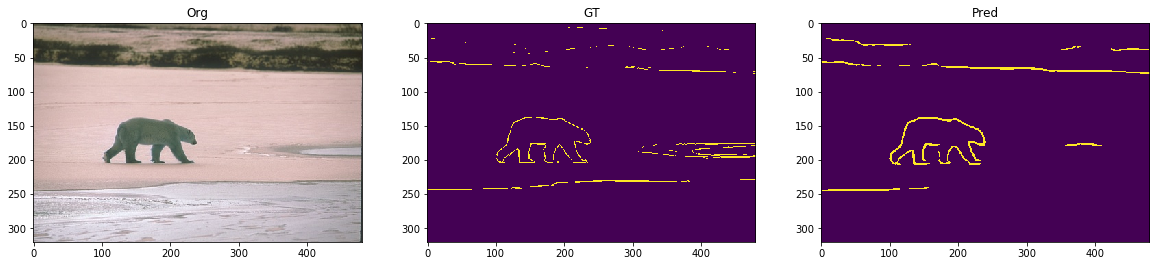

In [184]:
# Inspect some images
index = 0
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(pred_list[index])
plt.title('Pred')

In [ ]:
del train_set, val_set, xtrain, ytrain, xval, yval

## Alternative Methods for Comparison

## Canny

In [217]:
canny_predictions = []
for i in range(len(xtest.numpy())):
    img = np.transpose(xtest.numpy()[i, :, :, :], [1, 2, 0]).astype(np.uint8)
    canny_predictions.append(cv2.Canny(img,200,300) / 255)

In [224]:
accuracy_list = []
precision_list = []
recall_list = []
fvalue_list = []
map_list = []

for i in range(len(xtest.numpy())):
    pred = canny_predictions[i]
    gt = ytest.numpy()[i, 0, :, :]
    
    # metrics
    # accuracy
    accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

    # precision
    tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
    fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
    precision = tp / (tp + fp)

    # recall
    fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
    recall = tp / (tp + fn)

    # f-value
    if (precision == 0) & (recall == 0):
        fvalue = 0
    else:
        fvalue = 2 * precision * recall / (precision + recall)
    
# mean Average Precision
    m_ap = average_precision_score(y_true = gt.reshape(-1), y_score = pred.reshape(-1))
    
    print(f'Accuracy: {round(accuracy, 4)}, Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F-value: {round(fvalue, 4)}, m-AP: {round(m_ap, 4)}')

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    fvalue_list.append(fvalue)
    map_list.append(m_ap)

Accuracy: 0.9708, Precision: 0.2429, Recall: 0.2889, F-value: 0.2639, m-AP: 0.0831
Accuracy: 0.8513, Precision: 0.0296, Recall: 0.2851, F-value: 0.0536, m-AP: 0.019
Accuracy: 0.9784, Precision: 0.0659, Recall: 0.0535, F-value: 0.0591, m-AP: 0.0155
Accuracy: 0.9457, Precision: 0.0508, Recall: 0.1665, F-value: 0.0778, m-AP: 0.0199
Accuracy: 0.8865, Precision: 0.0312, Recall: 0.2163, F-value: 0.0546, m-AP: 0.0186
Accuracy: 0.838, Precision: 0.0366, Recall: 0.4416, F-value: 0.0677, m-AP: 0.0236
Accuracy: 0.8295, Precision: 0.0317, Recall: 0.2277, F-value: 0.0557, m-AP: 0.0243
Accuracy: 0.8678, Precision: 0.019, Recall: 0.249, F-value: 0.0353, m-AP: 0.012
Accuracy: 0.9857, Precision: 0.1039, Recall: 0.1608, F-value: 0.1262, m-AP: 0.0221
Accuracy: 0.9224, Precision: 0.0843, Recall: 0.282, F-value: 0.1298, m-AP: 0.0385
Accuracy: 0.927, Precision: 0.0452, Recall: 0.2064, F-value: 0.0741, m-AP: 0.0206
Accuracy: 0.9735, Precision: 0.1089, Recall: 0.22, F-value: 0.1457, m-AP: 0.032
Accuracy: 0.95

Accuracy: 0.9186, Precision: 0.0772, Recall: 0.2631, F-value: 0.1194, m-AP: 0.0358
Accuracy: 0.8996, Precision: 0.0529, Recall: 0.2277, F-value: 0.0858, m-AP: 0.028
Accuracy: 0.9112, Precision: 0.0293, Recall: 0.2369, F-value: 0.0521, m-AP: 0.0148
Accuracy: 0.8944, Precision: 0.0822, Recall: 0.2859, F-value: 0.1277, m-AP: 0.0428
Accuracy: 0.9446, Precision: 0.0951, Recall: 0.2859, F-value: 0.1428, m-AP: 0.0387
Accuracy: 0.9315, Precision: 0.1528, Recall: 0.1839, F-value: 0.1669, m-AP: 0.0586
Accuracy: 0.9259, Precision: 0.0341, Recall: 0.2687, F-value: 0.0606, m-AP: 0.0157
Accuracy: 0.9242, Precision: 0.0412, Recall: 0.2282, F-value: 0.0698, m-AP: 0.019
Accuracy: 0.9101, Precision: 0.0628, Recall: 0.257, F-value: 0.1009, m-AP: 0.0307
Accuracy: 0.9523, Precision: 0.0799, Recall: 0.2761, F-value: 0.1239, m-AP: 0.0309
Accuracy: 0.8822, Precision: 0.0289, Recall: 0.2408, F-value: 0.0516, m-AP: 0.0171
Accuracy: 0.9424, Precision: 0.1105, Recall: 0.1835, F-value: 0.1379, m-AP: 0.0408
Accurac

In [225]:
metrics = pd.DataFrame({'accuracy' : accuracy_list,
                        'precision' : precision_list,
                        'recall' : recall_list,
                        'fscore' : fvalue_list,
                        'mAP' : map_list})

In [226]:
metrics.mean()

accuracy     0.914373
precision    0.072026
recall       0.239080
fscore       0.101851
mAP          0.031291
dtype: float64

Text(0.5, 1.0, 'Pred')

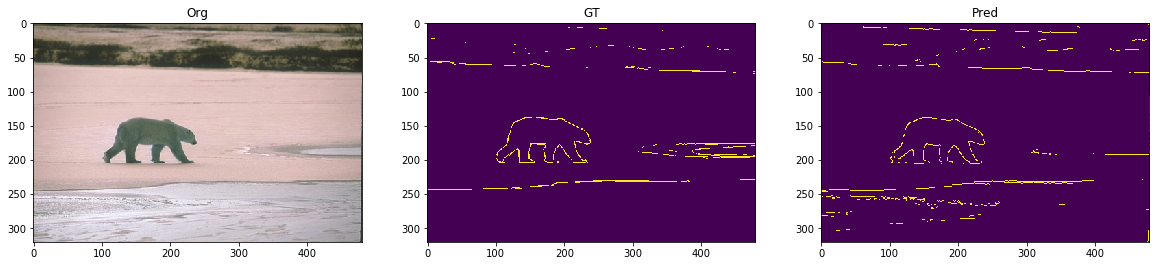

In [227]:
# Inspect some images
index = 0
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(canny_predictions[index])
plt.title('Pred')

## Sobel

In [228]:
sobel_predictions = [];
for i in range(len(xtest.numpy())):
    img = np.transpose(xtest.numpy()[i, :, :, :], [1, 2, 0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    grad_x = cv2.Sobel(img, cv2.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(img, cv2.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    (thresh, grad) = cv2.threshold(grad, 127, 255, cv2.THRESH_BINARY)
    
    sobel_predictions.append(grad)

In [229]:
accuracy_list = []
precision_list = []
recall_list = []
fvalue_list = []
map_list = []

for i in range(len(xtest.numpy())):
    pred = sobel_predictions[i]
    gt = ytest.numpy()[i, 0, :, :]
    
    pred_prob = pred.copy()
    pred = np.where(pred>=0.5, 1, 0)
    
    # metrics
    # accuracy
    accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

    # precision
    tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
    fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
    precision = tp / (tp + fp)

    # recall
    fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
    recall = tp / (tp + fn)

    # f-value
    if (precision == 0) & (recall == 0):
        fvalue = 0
    else:
        fvalue = 2 * precision * recall / (precision + recall)
        
    # mean Average Precision
    m_ap = average_precision_score(y_true = gt.reshape(-1), y_score = pred_prob.reshape(-1))
    
    print(f'Accuracy: {round(accuracy, 4)}, Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F-value: {round(fvalue, 4)}, m-AP: {round(m_ap, 4)}')

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    fvalue_list.append(fvalue)
    map_list.append(m_ap)

Accuracy: 0.9774, Precision: 0.2292, Recall: 0.1048, F-value: 0.1438, m-AP: 0.0403
Accuracy: 0.788, Precision: 0.0314, Recall: 0.4478, F-value: 0.0587, m-AP: 0.0222
Accuracy: 0.9705, Precision: 0.0463, Recall: 0.0679, F-value: 0.055, m-AP: 0.0149
Accuracy: 0.9632, Precision: 0.0555, Recall: 0.1045, F-value: 0.0725, m-AP: 0.0181
Accuracy: 0.854, Precision: 0.0323, Recall: 0.2979, F-value: 0.0582, m-AP: 0.0202
Accuracy: 0.8437, Precision: 0.0377, Recall: 0.4381, F-value: 0.0695, m-AP: 0.024
Accuracy: 0.8011, Precision: 0.0326, Recall: 0.2796, F-value: 0.0584, m-AP: 0.025
Accuracy: 0.864, Precision: 0.0243, Recall: 0.332, F-value: 0.0453, m-AP: 0.0146
Accuracy: 0.9856, Precision: 0.1169, Recall: 0.1891, F-value: 0.1445, m-AP: 0.0273
Accuracy: 0.9168, Precision: 0.0864, Recall: 0.3187, F-value: 0.1359, m-AP: 0.0415
Accuracy: 0.9582, Precision: 0.0612, Recall: 0.1361, F-value: 0.0845, m-AP: 0.0206
Accuracy: 0.9652, Precision: 0.0929, Recall: 0.2727, F-value: 0.1386, m-AP: 0.0328
Accuracy: 0

Accuracy: 0.9035, Precision: 0.1276, Recall: 0.2062, F-value: 0.1576, m-AP: 0.061
Accuracy: 0.9352, Precision: 0.0917, Recall: 0.3051, F-value: 0.1411, m-AP: 0.0401
Accuracy: 0.9221, Precision: 0.0438, Recall: 0.1924, F-value: 0.0714, m-AP: 0.021
Accuracy: 0.9105, Precision: 0.1293, Recall: 0.257, F-value: 0.1721, m-AP: 0.0601
Accuracy: 0.9017, Precision: 0.0542, Recall: 0.2243, F-value: 0.0873, m-AP: 0.0284
Accuracy: 0.8774, Precision: 0.0416, Recall: 0.2233, F-value: 0.0701, m-AP: 0.0254
Accuracy: 0.9292, Precision: 0.0475, Recall: 0.3083, F-value: 0.0823, m-AP: 0.0218
Accuracy: 0.873, Precision: 0.0784, Recall: 0.3439, F-value: 0.1277, m-AP: 0.0447
Accuracy: 0.9086, Precision: 0.0811, Recall: 0.4512, F-value: 0.1375, m-AP: 0.0454
Accuracy: 0.9254, Precision: 0.1523, Recall: 0.2191, F-value: 0.1797, m-AP: 0.0625
Accuracy: 0.9017, Precision: 0.0187, Recall: 0.1955, F-value: 0.0341, m-AP: 0.0108
Accuracy: 0.9189, Precision: 0.0479, Recall: 0.2914, F-value: 0.0822, m-AP: 0.0228
Accuracy

In [230]:
metrics = pd.DataFrame({'accuracy' : accuracy_list,
                        'precision' : precision_list,
                        'recall' : recall_list,
                        'fscore' : fvalue_list,
                        'mAP' : map_list})

In [231]:
metrics.mean()

accuracy     0.901472
precision    0.068617
recall       0.274403
fscore       0.099421
mAP          0.032078
dtype: float64

Text(0.5, 1.0, 'Pred')

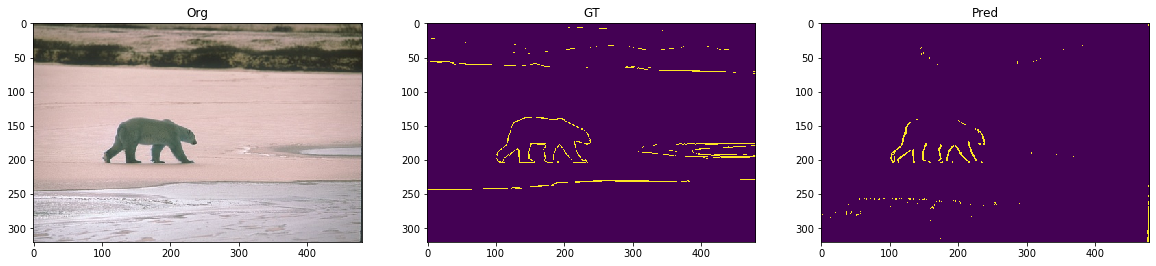

In [232]:
# Inspect some images
index = 0
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(sobel_predictions[index])
plt.title('Pred')

## HED

In [113]:
class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = (inputShape[2] - targetShape[2]) // 2
        self.xstart = (inputShape[3] - targetShape[3]) // 2
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]

In [114]:
cv2.dnn_registerLayer('Crop', CropLayer)

# Load the model.
prototxt = 'deploy.prototxt.txt'
caffemodel = 'hed_pretrained_bsds.caffemodel'
net = cv2.dnn.readNet(prototxt,caffemodel)

In [115]:
hed_predictions = [];
for i in range(len(xtest.numpy())):
    img = np.transpose(xtest.numpy()[i, :, :, :], [1, 2, 0]).astype(np.uint8)
    inp = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(480,320),
                                mean=(104.00698793, 116.66876762, 122.67891434),
                                swapRB=False, crop=False)
    net.setInput(inp)
    out = net.forward()
    out = out[0, 0]
    hed_predictions.append(out)

In [233]:
accuracy_list = []
precision_list = []
recall_list = []
fvalue_list = []
map_list = []

for i in range(len(xtest.numpy())):
    pred = hed_predictions[i]
    gt = ytest.numpy()[i, 0, :, :]
    
    pred_prob = pred.copy()
    pred = np.where(pred>=0.5, 1, 0)
    
    hed_predictions[i] = pred
    
    # metrics
    # accuracy
    accuracy = np.sum(pred == gt) / (gt.shape[0] * gt.shape[1])

    # precision
    tp = np.sum(pred[np.where(pred == 1)] == gt[np.where(pred == 1)])
    fp = np.sum(pred[np.where(pred == 1)] != gt[np.where(pred == 1)])
    precision = tp / (tp + fp)

    # recall
    fn = np.sum(pred[np.where(pred == 0)] != gt[np.where(pred == 0)])
    recall = tp / (tp + fn)

    # f-value
    if (precision == 0) & (recall == 0):
        fvalue = 0
    else:
        fvalue = 2 * precision * recall / (precision + recall)
    
    # mean Average Precision
    m_ap = average_precision_score(y_true = gt.reshape(-1), y_score = pred_prob.reshape(-1))
    
    print(f'Accuracy: {round(accuracy, 4)}, Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F-value: {round(fvalue, 4)}, m-AP: {round(m_ap, 4)}')

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    fvalue_list.append(fvalue)
    map_list.append(m_ap)

Accuracy: 0.8943, Precision: 0.1355, Recall: 0.8973, F-value: 0.2355, m-AP: 0.1235
Accuracy: 0.8918, Precision: 0.1028, Recall: 0.8189, F-value: 0.1827, m-AP: 0.0869
Accuracy: 0.9169, Precision: 0.113, Recall: 0.8132, F-value: 0.1985, m-AP: 0.0943
Accuracy: 0.8409, Precision: 0.0723, Recall: 0.8926, F-value: 0.1337, m-AP: 0.066
Accuracy: 0.9386, Precision: 0.1685, Recall: 0.776, F-value: 0.2768, m-AP: 0.1341
Accuracy: 0.8714, Precision: 0.0914, Recall: 0.9682, F-value: 0.167, m-AP: 0.0889
Accuracy: 0.8628, Precision: 0.1228, Recall: 0.849, F-value: 0.2146, m-AP: 0.1076
Accuracy: 0.8876, Precision: 0.0667, Recall: 0.8119, F-value: 0.1233, m-AP: 0.056
Accuracy: 0.9393, Precision: 0.0914, Recall: 0.9434, F-value: 0.1667, m-AP: 0.0866
Accuracy: 0.9086, Precision: 0.1363, Recall: 0.6473, F-value: 0.2252, m-AP: 0.0955
Accuracy: 0.8328, Precision: 0.057, Recall: 0.6952, F-value: 0.1053, m-AP: 0.0439
Accuracy: 0.8852, Precision: 0.0787, Recall: 0.9505, F-value: 0.1453, m-AP: 0.0753
Accuracy: 0

Accuracy: 0.7134, Precision: 0.0642, Recall: 0.9465, F-value: 0.1203, m-AP: 0.0619
Accuracy: 0.9258, Precision: 0.0943, Recall: 0.7202, F-value: 0.1667, m-AP: 0.0708
Accuracy: 0.8094, Precision: 0.1124, Recall: 0.8776, F-value: 0.1993, m-AP: 0.102
Accuracy: 0.8499, Precision: 0.0882, Recall: 0.8883, F-value: 0.1604, m-AP: 0.0801
Accuracy: 0.833, Precision: 0.166, Recall: 0.8634, F-value: 0.2784, m-AP: 0.1484
Accuracy: 0.9064, Precision: 0.0821, Recall: 0.9348, F-value: 0.1509, m-AP: 0.0773
Accuracy: 0.9042, Precision: 0.1004, Recall: 0.8397, F-value: 0.1793, m-AP: 0.0863
Accuracy: 0.8348, Precision: 0.094, Recall: 0.8584, F-value: 0.1695, m-AP: 0.0835
Accuracy: 0.7915, Precision: 0.0527, Recall: 0.9462, F-value: 0.0998, m-AP: 0.0505
Accuracy: 0.8238, Precision: 0.0638, Recall: 0.8953, F-value: 0.1191, m-AP: 0.0585
Accuracy: 0.9084, Precision: 0.1841, Recall: 0.7707, F-value: 0.2972, m-AP: 0.1476
Accuracy: 0.7896, Precision: 0.1296, Recall: 0.8883, F-value: 0.2262, m-AP: 0.119
Accuracy:

In [234]:
metrics = pd.DataFrame({'accuracy' : accuracy_list,
                        'precision' : precision_list,
                        'recall' : recall_list,
                        'fscore' : fvalue_list,
                        'mAP' : map_list})

In [235]:
metrics.mean()

accuracy     0.869808
precision    0.106470
recall       0.836331
fscore       0.185976
mAP          0.091838
dtype: float64

Text(0.5, 1.0, 'Pred')

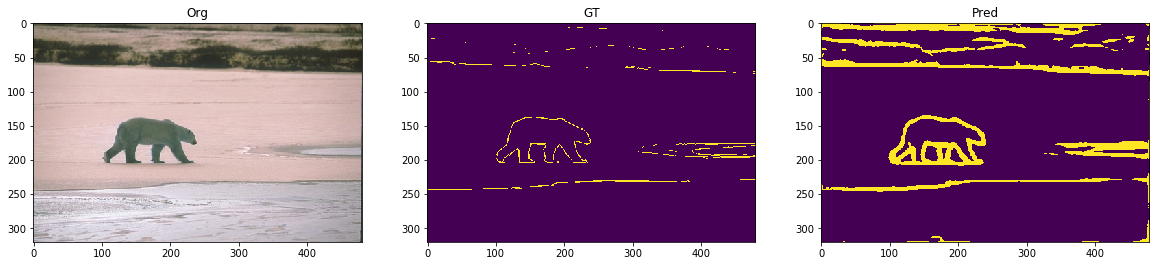

In [236]:
# Inspect some images
index = 0
plt.subplots(1,3,figsize=(20,20))

plt.subplot(1, 3, 1)
plt.imshow(org_list[index])
plt.title('Org')

plt.subplot(1, 3, 2)
plt.imshow(gt_list[index])
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(hed_predictions[index])
plt.title('Pred')